<div style="background-color:#e0f7fa; padding:40px; border-radius:10px; text-align:center; border: 3px solid #00acc1;">
    <h1 style="margin:0; font-size:32px; font-weight:bold;">Matching Notebook Example</h1>
    <p style="margin:20px 0 0 0; font-size:18px;">Last updated: 2024.08.27 | Authors: Jiawei Zhou, Scarlett Liu, Jeff Siegert</p>
</div>

<span style="background-color: #ffcccc; display: block; padding: 10px; border-radius: 5px;">

# ⚠️ **MUST READ**

<h5><b>First-time User</b></h5>

Focus on the **red sections** to customize the notebook for your use case. **Yellow sections** are optional but should be reviewed.

---

<h5><b>Data Prerequisites</b></h5>

1. **ID Column**: Include a unique identifier (e.g., `cluster_id`, `org_id`).
2. **Date Fields**: Your dataset needs two date fields: **event_month** (treatment month) and **ds_month** (cluster-level time period).
3. **Primary Key**: The primary key should combine the unique ID (e.g., `cluster_id`) with the `ds_month` to uniquely identify each record.
4. **Treatment Flag**: Include a column indicating whether an ID is in the treatment group (1) or control group (0).
5. **Column Selection**: Pre-select columns for matching based on your domain knowledge or experience. The notebook won't automatically pick the most relevant metrics.

---


<h5><b>Data Manipulation Tips</b></h5>

1. **Outlier Removal**: 
   - We recommend removing outliers during the data manipulation process to improve the robustness of your analysis. However, be cautious, especially with treatment groups that have a low sample size, as removing outliers could significantly reduce the number of observations available for matching.
  
2. **Standardization of Numeric Columns**:
   - We provide a script to standardize numeric columns for vector matching and it’s recommended to use this script to ensure all features contribute equally.

3. **Processing Time**:
   - The matching script can take a considerable amount of time, particularly with larger datasets. Please ensure that your computer is either fully charged or connected to a power source to avoid interruptions during execution.

---

<h5><b>Limitations</b></h5>

1. **Processing Time**: Matching may be slow, especially with large datasets. Reduce the control group size to speed up processing if needed.
2. **Potential Bugs**: Modifying the notebook might introduce bugs. Contact the authors if you encounter issues.

</span>

<div style="background-color:#ccffcc; padding:20px; border-radius:10px; text-align:left;">
    <h1 style="margin:0;">STEP 1: Install and Import Necessary Packages</h1>
</div>

<div style="background-color:#ffcccc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Required</strong>: Install and import the necessary packages.</p>
</div>

In [1]:
# Install necessary packages
# !pip install pandas numpy matplotlib seaborn scipy scikit-learn
# !pip3 install mongodstools --extra-index-url https://pypi.mongodb.name
# !pip3 install mongocausalml --extra-index-url https://pypi.mongodb.name

# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import featuretools as ft
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import datetime as dt
import time
import trino
import getpass
from mongodstools import logger
from mongodstools import trino_helper
from mongocausalml.matchingtool.matcher_core import Matcher
from mongocausalml.matchingtool.data_validator import DataFrameValidator
import mongocausalml.matchingtool.utils as utils
import mongocausalml.matchingtool.helper as helper

/Users/jiawei.zhou/Library/Python/3.9/lib/python/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# ---- Execution Section: No Action Required ----

# Configures pandas to display up to 100 rows and columns.

# Set the maximum number of displayed rows
pd.set_option("display.max_rows", 100)

# Set the maximum number of displayed columns
pd.set_option("display.max_columns", 100)

<div style="background-color:#ccffcc; padding:20px; border-radius:10px; text-align:left;">
    <h1 style="margin:0;">STEP 2: Read and Process Data</h1>
</div>

<div style="background-color:#ffcccc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Required</strong>: Replace the user email to connect to Trino, or upload the CSV file.</p>
</div>

In [3]:
# Connects to a Presto database, executes a SQL query, and structures the result into a pandas DataFrame.

# Prompt the user for username and password
username = input("Enter your Trino username: ")
password = getpass.getpass(prompt="Enter your Trino password: ")

<div style="background-color:#ffcccc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Required</strong>: Replace with your SQL query to retrieve the data.</p>
</div>

In [4]:
# --- IMPORTANT: UPDATE THE SQL QUERY BELOW ---
qry = """
SELECT
    *,
    month_date AS ds_month
FROM
    awsdatacatalog.growth_analytics.matching_tool_input_email_ex
"""

In [5]:
# ---- Execution Section: No Action Required ----

trino = trino_helper.TrinoHelper(
    username=username, password=password, host="presto-gateway.corp.mongodb.com"
)
df = trino.get_data_sql(qry)

/Users/jiawei.zhou/Library/Python/3.9/lib/python/site-packages/mongodstools/trino_helper.py:91: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(txt_query, self.conn, chunksize=chunksize)


<div style="background-color:#ffffcc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Attention</strong>: Identify the important columns for matching.</p>
</div>

In [6]:
# Identify the columns based on the criteria provided
id_columns = [col for col in df.columns if "id" in col.lower()]
date_columns = ["event_month", "ds_month"]
target_columns = ["treatment_flag"]
other_columns = [
    col for col in df.columns if col not in id_columns + date_columns + target_columns
]

# Display the separated columns with their actual names
print("ID Columns:")
print(id_columns)

print("\nDate Columns:")
print(date_columns)

print("\nTreatment Flag:")
print(target_columns)

print("\nPotential Matching Columns:")
print(other_columns)

ID Columns:
['org_id']

Date Columns:
['event_month', 'ds_month']

Treatment Flag:
['treatment_flag']

Potential Matching Columns:
['month_date', 'region', 'channel_group', 'self_serve_or_sales_sold', 'cluster_tenure_in_months', 'mrr', 'max_cluster_size_ordinal', 'variant_flag']


<div style="background-color:#ffcccc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Required</strong>: Replace with relevant column names for key variables.</p>
</div>

In [7]:
# Define key columns for matching and tracking

# --- IMPORTANT: DEFINE THE PRIMARY IDENTIFIER ---
primary_identifier = "org_id"

# --- IMPORTANT: DEFINE COLUMNS FOR MATCHING ---
columns_for_matching = [
    "region",
    "channel_group",
    "self_serve_or_sales_sold",
    "cluster_tenure_in_months",
    "mrr",
    "max_cluster_size_ordinal"
]

# --- IMPORTANT: DEFINE THE EVENT MONTH COLUMN ---
event_month_column = "event_month"

# --- IMPORTANT: DEFINE THE DS MONTH COLUMN ---
ds_month_column = "ds_month"

# --- IMPORTANT: DEFINE THE TREATMENT FLAG ---
treatment_flag = "treatment_flag"

In [8]:
# ---- Execution Section: No Action Required ----

# Apply function to the DataFrame
df_selected = helper.keep_columns_and_create_treatment_flag(
    df,
    primary_identifier,
    columns_for_matching,
    event_month_column,
    ds_month_column,
    treatment_flag,
)

# Create a backup DataFrame
df_before = df_selected.copy()

# Display the first few rows
df_selected.head()

,org_id,region,channel_group,self_serve_or_sales_sold,cluster_tenure_in_months,mrr,max_cluster_size_ordinal,event_month,ds_month,treatment_flag
0,5f6b1c815c057a0db69f291a,EMEA,Paid Search,Self Serve,46,2326.558679,7.0,2024-07-01,2024-07-01,1
1,5fb2a1ea6dbf6b0a4a24ead3,EMEA,Organic Search,Self Serve,44,173.493140,3.0,2024-07-01,2024-07-01,1
2,65020713085b8a47517aac43,AMER,Organic Search,Sales Sold,10,2852.128955,6.0,2024-07-01,2024-07-01,1
3,5ac4d43796e8217ac0f490cb,EMEA,Direct,Self Serve,75,767.156824,5.0,2024-07-01,2024-07-01,1
4,6470ca760ec696195b65d5c9,EMEA,Partner,Self Serve,14,3209.066775,6.0,2024-07-01,2024-07-01,1


<div style="background-color:#ffcccc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Required</strong>: Review the validation result and act accordingly.</p>
</div>

In [9]:
# Validates the DataFrame for matching using specified identifier and treatment flag columns.

validator = DataFrameValidator(
    df_selected, id_column=primary_identifier, assignment_column="treatment_flag"
)
validator.validate()

[PASS] Required Columns Check: Required Columns Check passed.
[FAIL] Null Value Check: Null Value Check failed. Reason: The DataFrame contains null values in the following columns: region (36 missing), mrr (2845 missing), max_cluster_size_ordinal (2449 missing)
[PASS] Boolean Column Check: All boolean columns have valid values (True/False) with no nulls.
[PASS] Assignment Column Check: The treatment flag column contains only 0 and 1 values.
[PASS] ID + ds_month Uniqueness Check: ID + ds_month Uniqueness Check passed.

[DataFrame Validation Summary]
[WARNING] DataFrame Validation: Null Value Check failed, indicating columns with missing values. It's recommended to fill these, but this won't block the matching script from running.


<div style="background-color:#ccffcc; padding:20px; border-radius:10px; text-align:left;">
    <h1 style="margin:0;">STEP 3: Data Manipulation</h1>
</div>

<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Attention</strong>: Check <u>data types</u> and <u>missing values</u> for each column.</p>
</div>

In [10]:
# Create a DataFrame with data types, number of missing values, and missing value percentages
result_df = pd.DataFrame(
    {
        "Data Type": df_selected.dtypes,
        "Number of Missing Values": df_selected.isnull().sum(),
        "Missing Value Percentage": (df_selected.isnull().mean() * 100)
        .round(2)
        .astype(str)
        + "%",
    }
)

# Display the result
result_df

,Data Type,Number of Missing Values,Missing Value Percentage
org_id,object,0,0.0%
region,object,36,0.06%
channel_group,object,0,0.0%
self_serve_or_sales_sold,object,0,0.0%
cluster_tenure_in_months,int64,0,0.0%
mrr,float64,2845,4.35%
max_cluster_size_ordinal,float64,2449,3.74%
event_month,datetime64[ns],65076,99.49%
ds_month,datetime64[ns],0,0.0%
treatment_flag,int64,0,0.0%


<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Optional</strong>: Fill in <u>missing values</u> if necessary.</p>
</div>

In [11]:
# Efficient handling of missing values in place, excluding the event_month column:

# List of columns to process, excluding event_month
cols_to_process = df_selected.columns[df_selected.columns != "event_month"]

# Detect numeric columns once, to be used across options
numeric_cols = (
    df_selected[cols_to_process].select_dtypes(include=["float64", "int64"]).columns
)

# Select one of the options below by uncommenting it

# Option 1: Drop rows with any missing values, excluding event_month
# if df_selected[cols_to_process].isnull().any().any():
#     df_selected.dropna(subset=cols_to_process, inplace=True)

# Option 2: Fill null values with a specific value (e.g., 0), excluding event_month
# if df_selected[cols_to_process].isnull().any().any():
#     df_selected.loc[:, cols_to_process] = df_selected.loc[:, cols_to_process].fillna(0)

# Option 3: Fill null values with the mean of the column (for numeric columns), excluding event_month
# if df_selected[numeric_cols].isnull().any().any():
#     df_selected.loc[:, numeric_cols] = df_selected.loc[:, numeric_cols].fillna(df_selected[numeric_cols].mean())

# Option 4: Fill null values with the median of the column (for numeric columns), excluding event_month
# if df_selectedd.lo[numeric_cols].isnull().any().any():
#     df_selectec[:, numeric_cols] = df_selected.loc[:, numeric_cols].fillna(df_selected[numeric_cols].median())

# Option 5: Fill null values with the mode (most frequent value) of the column, excluding event_month
# for col in cols_to_process:
#     if df_selected[col].isnull().any():
#         mode_value = df_selected[col].mode()[0]
#         df_selected.loc[:, col] = df_selected.loc[:, col].fillna(mode_value)

# Option 6: Forward fill (propagate the last valid observation forward), excluding event_month
# if df_selected[cols_to_process].isnull().any().any():
#     df_selected.loc[:, cols_to_process] = df_selected.loc[:, cols_to_process].fillna(method="ffill")

# Option 7: Backward fill (propagate the next valid observation backward), excluding event_month
# if df_selected[cols_to_process].isnull().any().any():
#     df_selected.loc[:, cols_to_process] = df_selected.loc[:, cols_to_process].fillna(method="bfill")

<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Optional</strong>: Change variable <u>data types</u> if necessary.</p>
</div>

In [12]:
# # Define the columns for each conversion type
# numeric_columns = [
#     "cluster_tenure_in_months",
#     "mrr",
#     "cluster_tenure_in_months",
#     "max_cluster_size_ordinal",
# ]

# categorical_columns = ["region", "channel_group", "self_serve_or_sales_sold"]

# boolean_columns = [
#     "treatment_flag",
# ]

# date_columns = ["ds_month", "event_month"]

In [13]:
# # ---- Execution Section: No Action Required ----

# # Convert specified columns to numeric
# for col in numeric_columns:
#     if col in df_selected.columns:
#         df_selected[col] = pd.to_numeric(df_selected[col], errors="coerce")

# # Convert specified columns to categorical
# df_selected[categorical_columns] = df_selected[categorical_columns].astype("category")

# # Convert specified columns to boolean
# df_selected[boolean_columns] = df_selected[boolean_columns].astype(bool)

# # Convert specified columns to datetime
# df_selected[date_columns] = df_selected[date_columns].apply(
#     pd.to_datetime, errors="coerce"
# )

<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Optional:</strong> Address <u>outliers</u> if necessary.</p>
</div>

Sample size before outlier removal: 5451
Sample size after outlier removal: 4924


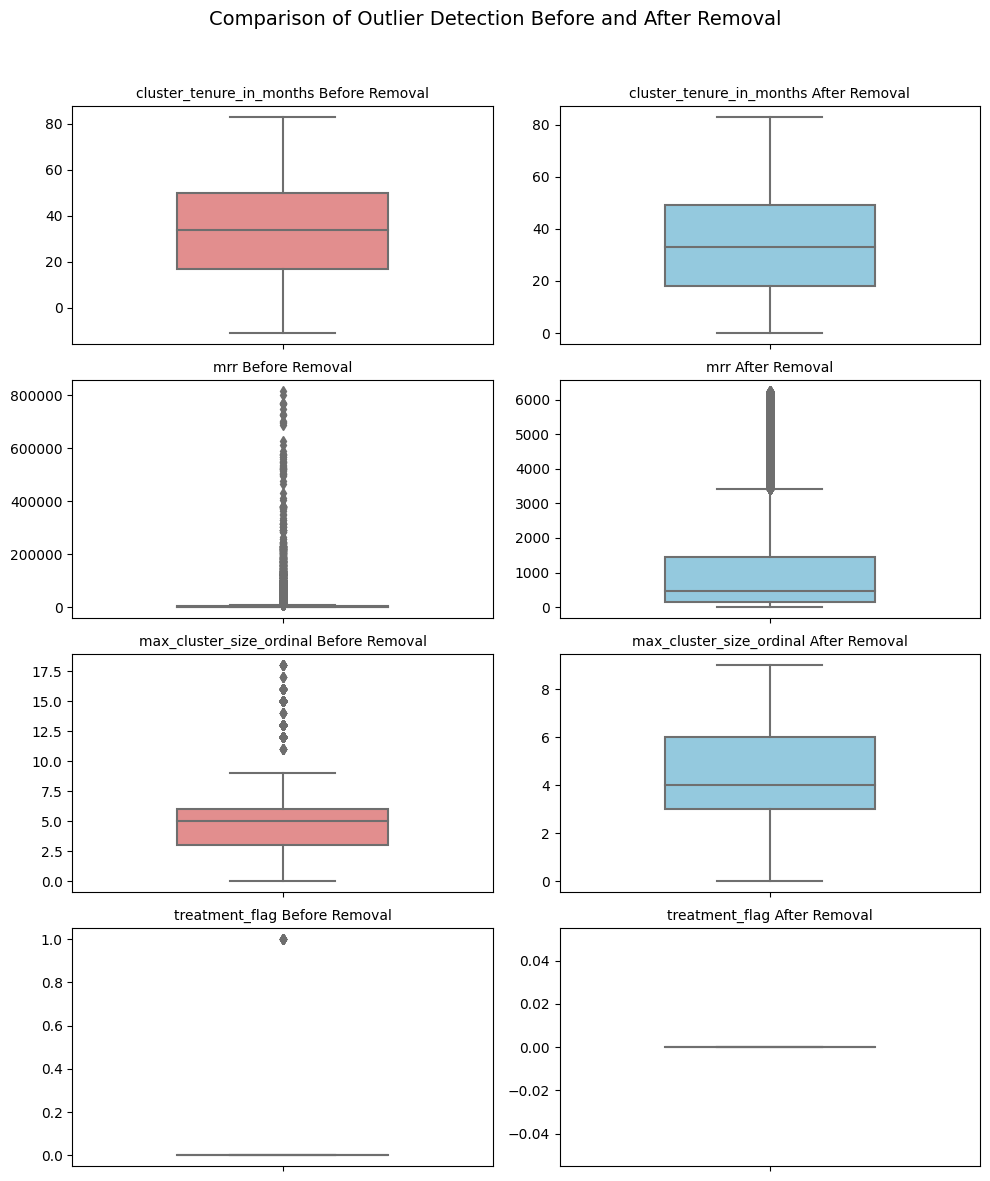

No changes made to the DataFrame.


In [14]:
# Define the primary ID column
primary_id_column = primary_identifier

# Remove outliers
df_selected_no_outliers = helper.remove_outliers_iqr(df_selected)

# Visualize side-by-side comparison of outliers before and after removal with smaller plots
helper.visualize_outliers_comparison(
    df_selected, df_selected_no_outliers, primary_id_column
)

# Ask the user if they want to implement the outlier removal process
use_no_outliers = input("Implement outlier removal? (yes/no): ").strip().lower()

if use_no_outliers == "yes":
    df_selected = df_selected_no_outliers
    print("Outliers removed. DataFrame updated.")
else:
    print("No changes made to the DataFrame.")

<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Optional:</strong> Consider sampling the control group if the <u>sample size</u> is too large for matching.</p>
</div>

In [15]:
# Display unique primary IDs in the control group before sampling
original_control_size = df_selected[df_selected["treatment_flag"] == 0][
    primary_id_column
].nunique()
print(
    f"Original control group size (unique {primary_id_column}): {original_control_size}"
)

# Apply the sampling function to your DataFrame with a 50% sample fraction
df_sampled = helper.sample_control_group(
    df_selected, primary_id_column=primary_id_column, sample_fraction=0.5
)

# Display unique primary IDs in the control group after sampling
sampled_control_size = df_sampled[df_sampled["treatment_flag"] == 0][
    primary_id_column
].nunique()
print(
    f"Sampled control group size (unique {primary_id_column}): {sampled_control_size}"
)

# Ask the user if they want to use the sampled control group to reduce matching time
use_sampled_control_group = (
    input("Use sampled control group to speed up matching? (yes/no): ").strip().lower()
)

if use_sampled_control_group == "yes":
    df_selected = df_sampled
    print("Control group updated with the sampled group.")
else:
    print("No changes made to the DataFrame.")

Original control group size (unique org_id): 5451
Sampled control group size (unique org_id): 2726
No changes made to the DataFrame.


<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Optional:</strong> Consider </>standardizing</u> numeric variables to improve matching performance.</p>
</div>

In [16]:
# Create a backup DataFrame
df_backup = df_selected.copy()

# Automatically detect numeric columns in df_selected, excluding 'treatment_flag'
numeric_columns = df_selected.select_dtypes(include=["number"]).columns
numeric_columns = numeric_columns.drop("treatment_flag", errors="ignore")

# Ask the user if they want to standardize numeric columns
standardize = input("Standardize numeric columns? (yes/no): ").strip().lower()

if standardize == "yes":
    # Standardize the numeric columns, excluding 'treatment_flag'
    scaler = StandardScaler()
    df_selected[numeric_columns] = scaler.fit_transform(df_selected[numeric_columns])

    print("Numeric columns standardized.")
else:
    print("No changes made. Numeric columns remain unchanged.")

# Display the first few rows to verify the transformation (if applied)
df_selected.head()

Numeric columns standardized.


,org_id,region,channel_group,self_serve_or_sales_sold,cluster_tenure_in_months,mrr,max_cluster_size_ordinal,event_month,ds_month,treatment_flag
0,5f6b1c815c057a0db69f291a,EMEA,Paid Search,Self Serve,0.542580,-0.108575,0.918146,2024-07-01,2024-07-01,1
1,5fb2a1ea6dbf6b0a4a24ead3,EMEA,Organic Search,Self Serve,0.448565,-0.201226,-0.959844,2024-07-01,2024-07-01,1
2,65020713085b8a47517aac43,AMER,Organic Search,Sales Sold,-1.149695,-0.085959,0.448649,2024-07-01,2024-07-01,1
3,5ac4d43796e8217ac0f490cb,EMEA,Direct,Self Serve,1.905801,-0.175680,-0.020849,2024-07-01,2024-07-01,1
4,6470ca760ec696195b65d5c9,EMEA,Partner,Self Serve,-0.961664,-0.070599,0.448649,2024-07-01,2024-07-01,1


<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Attention</strong>: Check the sample size between treatment and control groups before matching.</p>
</div>

In [17]:
# Calculate the number of unique primary IDs in each group
treatment_group_size = df_selected[df_selected["treatment_flag"] == 1][
    primary_identifier
].nunique()
control_group_size = df_selected[df_selected["treatment_flag"] == 0][
    primary_identifier
].nunique()

# Print the sizes of the treatment and control groups before matching
print(
    f"Sample Size Before Matching - Treatment Group (unique primary IDs): {treatment_group_size}"
)
print(
    f"Sample Size Before Matching - Control Group (unique primary IDs): {control_group_size}"
)

Sample Size Before Matching - Treatment Group (unique primary IDs): 28
Sample Size Before Matching - Control Group (unique primary IDs): 5451


<div style="background-color:#ffcccc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Required</strong>: Review the validation result and act accordingly.</p>
</div>

In [18]:
# Validates the DataFrame for matching using specified identifier and treatment flag columns.

validator = DataFrameValidator(
    df_selected, id_column=primary_identifier, assignment_column="treatment_flag"
)
validator.validate()

[PASS] Required Columns Check: Required Columns Check passed.
[FAIL] Null Value Check: Null Value Check failed. Reason: The DataFrame contains null values in the following columns: region (36 missing), mrr (2845 missing), max_cluster_size_ordinal (2449 missing)
[PASS] Boolean Column Check: All boolean columns have valid values (True/False) with no nulls.
[PASS] Assignment Column Check: The treatment flag column contains only 0 and 1 values.
[PASS] ID + ds_month Uniqueness Check: ID + ds_month Uniqueness Check passed.

[DataFrame Validation Summary]
[WARNING] DataFrame Validation: Null Value Check failed, indicating columns with missing values. It's recommended to fill these, but this won't block the matching script from running.


<div style="background-color:#ccffcc; padding:20px; border-radius:10px; text-align:left;">
    <h1 style="margin:0;">STEP 4: Execute Matching Process</h1>
</div>

In [19]:
# Initializes the Matcher, performs matching, and displays the concatenated result.

# Initialize the matcher with the correct parameters using df_selected
matching_strictness = 0.5
with_replacement = False

# Call the Matcher class with the necessary parameters
matcher_no_replacement = Matcher(
    df_selected,
    primary_identifier=primary_identifier,
    event_month_column=event_month_column,
    ds_month_column=ds_month_column,
    matching_strictness=matching_strictness,
    with_replacement=with_replacement,
)

# Run the match and get the concatenated result for all months
df_matched_pairs = matcher_no_replacement.get_result_for_all_month()

{"level": "INFO", "line": "mongodstools:__init__:33", "message": "Matcher initiated", "time": "2024-08-27 16:32:53.185"}
{"level": "INFO", "line": "mongodstools:log_treatment_flag:76", "message": "Treatment count: 28", "time": "2024-08-27 16:32:53.193"}
{"level": "INFO", "line": "mongodstools:log_treatment_flag:77", "message": "Control count: 65384", "time": "2024-08-27 16:32:53.194"}
{"level": "INFO", "line": "mongodstools:feature_type:66", "message": "Numerical Features : ['cluster_tenure_in_months', 'mrr', 'max_cluster_size_ordinal']", "time": "2024-08-27 16:32:53.198"}
{"level": "INFO", "line": "mongodstools:feature_type:67", "message": "String Features: ['channel_group', 'self_serve_or_sales_sold']", "time": "2024-08-27 16:32:53.199"}
{"level": "INFO", "line": "mongodstools:get_list_month:55", "message": "Event months in the dataframe: [Timestamp('2024-07-01 00:00:00'), Timestamp('2023-08-01 00:00:00'), Timestamp('2023-10-01 00:00:00'), Timestamp('2023-12-01 00:00:00'), Timestamp(

<div style="background-color:#ccffcc; padding:20px; border-radius:10px; text-align:left;">
    <h1 style="margin:0;">STEP 5: Create Matched Pairs DataFrame</h1>
</div>

In [20]:
"""
Purpose: This script checks if the previous dataset (`df_selected`) was standardized,
and if so, merges it back with the matched pairs dataset (`df_matched_pairs`) to
restore the original values where applicable.
"""

# Check if df_backup exists and merge it with df_matched_pairs
if "df_backup" in globals():
    df_merged = df_matched_pairs.merge(
        df_backup,
        on=[primary_identifier, "treatment_flag", "ds_month"],
        how="left",
        suffixes=("", "_backup"),
    )

    # Keep and rename columns with '_backup' suffix
    columns_to_keep = [col for col in df_merged.columns if col.endswith("_backup")]
    df_merged = df_merged[
        [primary_identifier, "treatment_flag", "ds_month"] + columns_to_keep
    ]
    df_merged.columns = [col.replace("_backup", "") for col in df_merged.columns]

    # Update df_matched_pairs with the merged data
    df_matched_pairs = df_merged

# Notify the user and display the first few rows
print("The matched pairs have been stored in 'df_matched_pairs'.")
df_matched_pairs.head()

The matched pairs have been stored in 'df_matched_pairs'.


,org_id,treatment_flag,ds_month,region,channel_group,self_serve_or_sales_sold,cluster_tenure_in_months,mrr,max_cluster_size_ordinal,event_month
0,5f6b1c815c057a0db69f291a,1.0,2024-07-01,EMEA,Paid Search,Self Serve,46,2326.558679,7.0,2024-07-01
1,5fb2a1ea6dbf6b0a4a24ead3,1.0,2024-07-01,EMEA,Organic Search,Self Serve,44,173.493140,3.0,2024-07-01
2,65020713085b8a47517aac43,1.0,2024-07-01,AMER,Organic Search,Sales Sold,10,2852.128955,6.0,2024-07-01
3,5ac4d43796e8217ac0f490cb,1.0,2024-07-01,EMEA,Direct,Self Serve,75,767.156824,5.0,2024-07-01
4,6470ca760ec696195b65d5c9,1.0,2024-07-01,EMEA,Partner,Self Serve,14,3209.066775,6.0,2024-07-01


<div style="background-color:#ffcccc; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Action Required</strong>: Provide the catalog, schema, and table name to create the Trino table for analysis.</p>
</div>

In [21]:
# Example usage with df_matched_pairs

# --- IMPORTANT: CHANGE THE CATALOG, SCHEMA, AND TABLE NAMES BELOW ---
helper.create_trino_table_from_df(
    df_matched_pairs,
    "awsdatacatalog",  # <-- Replace with your catalog name
    "product_analytics",  # <-- Replace with your schema name
    "matching_tool_example_sltest",  # <-- Replace with your table name
    trino.conn,
)

Existing table 'matching_tool_example_sltest' in schema 'product_analytics' dropped.
Table 'matching_tool_example_sltest' was successfully created in schema 'product_analytics'.


<div style="background-color:#ccffcc; padding:20px; border-radius:10px; text-align:left;">
    <h1 style="margin:0;">STEP 6: Matching Performance Evaluation</h1>
</div>

<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Attention</strong>: Check the sample size between treatment and control groups after matching.</p>
</div>

In [22]:
# Calculate the number of unique primary IDs in each group
treatment_group_size = df_matched_pairs[df_matched_pairs["treatment_flag"] == 1][
    primary_identifier
].nunique()
control_group_size = df_matched_pairs[df_matched_pairs["treatment_flag"] == 0][
    primary_identifier
].nunique()

# Print the sizes of the treatment and control groups after matching
print(
    f"Sample Size After Matching - Treatment Group (unique primary IDs): {treatment_group_size}"
)
print(
    f"Sample Size After Matching - Control Group (unique primary IDs): {control_group_size}"
)

# Check if the sample sizes are not equal and provide an explanation
if treatment_group_size != control_group_size:
    print(
        "Note: The control group may have fewer unique IDs than the treatment group because some control units were matched to multiple treatment units."
    )

Sample Size After Matching - Treatment Group (unique primary IDs): 28
Sample Size After Matching - Control Group (unique primary IDs): 28


<div style="background-color:#ffffe0; padding:15px; border-radius:10px; margin-top:10px;">
    <p style="margin:0;"><strong>Attention</strong>: Please review the distribution differences before and after matching to assess the effectiveness of the process.</p>
    <p style="margin:0;"><strong>Note</strong>: The first section covers numeric variables; the second covers categorical variables.</p>
</div>

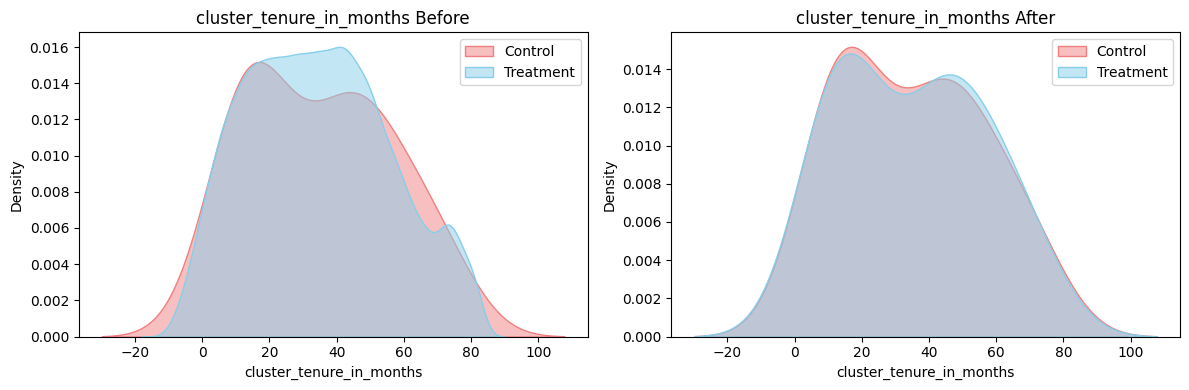

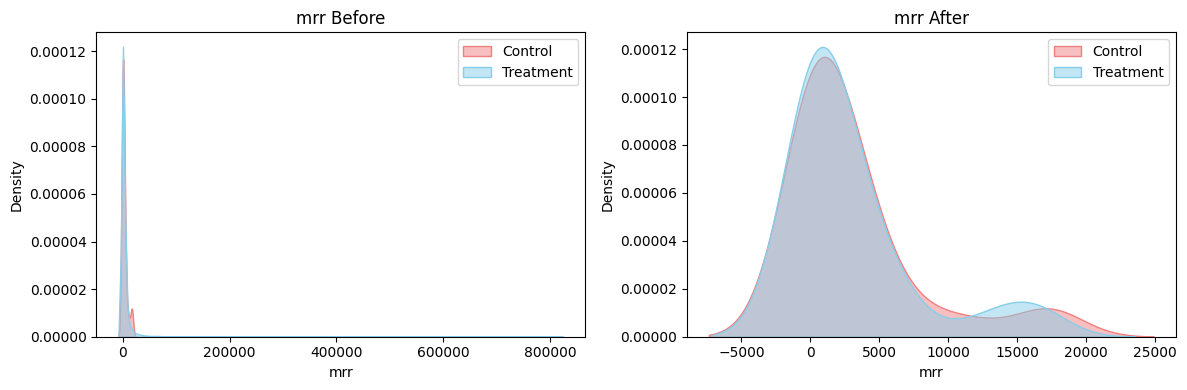

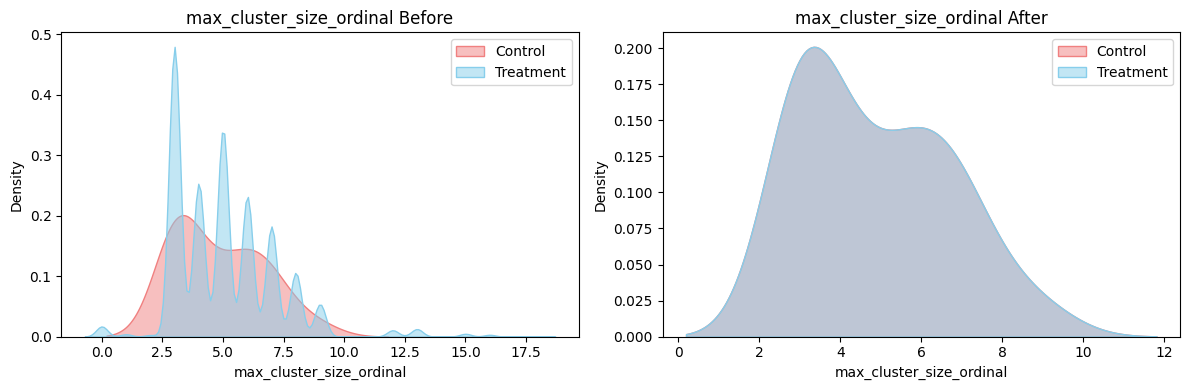

In [23]:
# Detect data types: separate numerical and categorical columns, excluding 'treatment_flag'
numerical_cols = df_before.select_dtypes(include=["number"]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != "treatment_flag"]

# Plot density plots for numerical variables, excluding 'treatment_flag'
if numerical_cols:
    helper.plot_density(df_before, df_matched_pairs, numerical_cols)

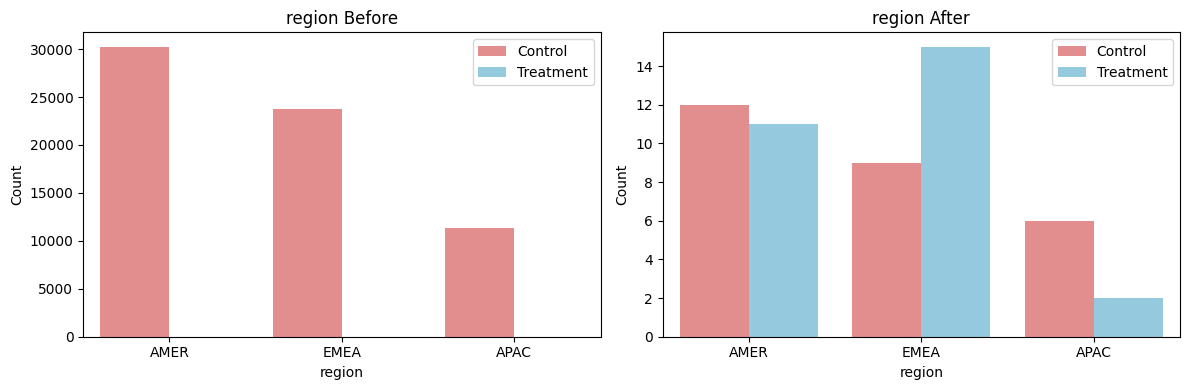

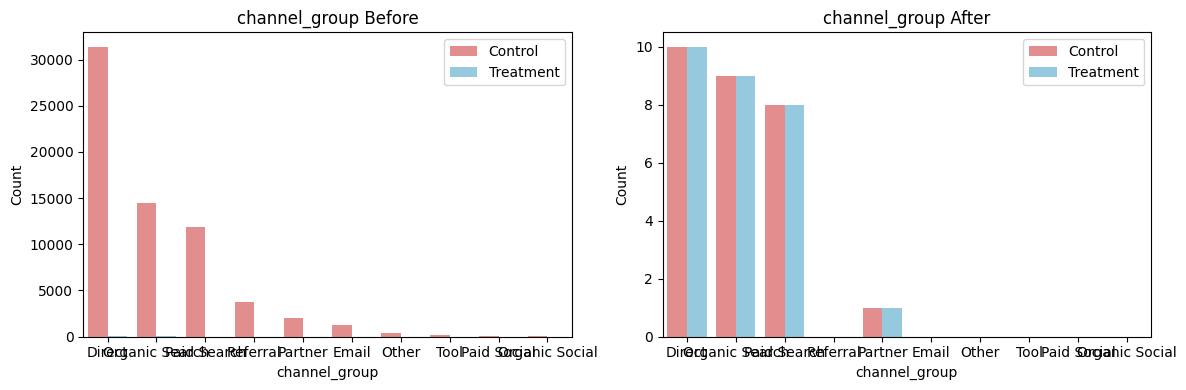

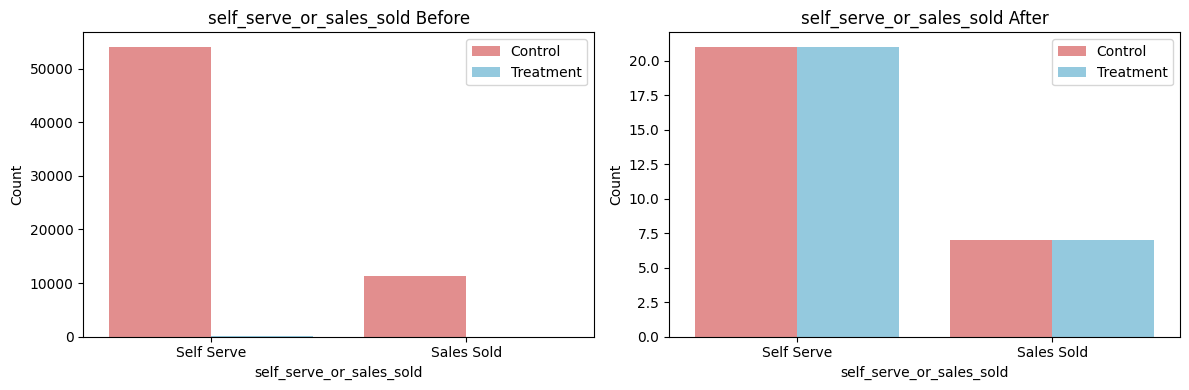

In [24]:
# Get non-ID and non-date/month categorical columns from df_before
categorical_cols = helper.get_non_id_non_date_categorical_columns(df_before)

# Limit categorical variables to top 10 values
df_before_limited = helper.limit_to_top_values(df_before, categorical_cols)
df_after_limited = helper.limit_to_top_values(df_matched_pairs, categorical_cols)

# Enforce consistent order between before and after dataframes
df_before_limited, df_after_limited = helper.enforce_consistent_order(
    df_before_limited, df_after_limited, categorical_cols
)

# Plot bar plots for non-ID, non-date/month categorical variables with limited top values
if categorical_cols:
    helper.plot_categorical(df_before_limited, df_after_limited, categorical_cols)